<a href="https://colab.research.google.com/github/ibpsa/project1-boptest-gym/blob/master/docs/tutorials/CCAI%20Summer%20School%202022/Tutorial_2_Building_Control_with_RL_using_BOPTEST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Key Learning Objectives** 🎯


This is an introductory, hands-on tutorial to guide you through the main concepts of Reinforcement Learning (RL) for controlling Heating, Ventilation and Air Conditioning (HVAC) systems for buildings. 
We are going to apply RL to a building emulator from the Building Optimization Testing (BOPTEST) framework **[1]** using the BOPTEST-Gym interface **[2]**. 
BOPTEST is a framework for performance benchmarking of control algorithms.
Further information and documentation can be found here: 

[https://ibpsa.github.io/project1-boptest/](https://ibpsa.github.io/project1-boptest/)

You will learn:

- What RL is, how it works and how it can be used in the application of building energy management. 
- The most popular standard for representing general RL problems: OpenAI-Gym.
- The BOPTEST API and its Gym interface. 

📌 **Note**: This tutorial was prepared for use with BOPTEST v0.3.0. 
and will make usage of a web-based version of BOPTEST (called "BOPTEST-Service") so as not to require installation of any BOPTEST software on a user's own device. It is also possible to use BOPTEST on a user's own (local) device. Both the web-based and local versions have the same functionality, and will produce the same results, with only small changes in the API (changing the BOPTEST-service url to your localhost url, that is, to: `http://127.0.0.1:5000/<request>`). 

**EDIT**: This tutorial was originally developed with BOPTEST v0.2.0. and has been updated to version 0.3.0. on *Oct 25, 2022*. There are just small changes required for this update, basically retrieving the `'payload'` after each request. That is the origin of the differences between the notebook explained in the recording and this updated notebook.  

# **Outline** ⏰


[Part 1: Background](#background)
  1. [Introduction to Reinforcement Learning](#introRL)
  1. [Application of Reinforcement Learning in buildings](#applicationRL)

[Part 2: The OpenAI-Gym standard](#openAIGym)
  1. [What is OpenAI-Gym?](#whatIsOpenAIGym)
  1. [Example using an OpenAI-Gym environment](#exampleOpenAIGym)

[Part 3: The Building Optimization Testing (BOPTEST) Framework](#boptest)
  1. [What is BOPTEST?](#whatIsBoptest)
  1. [Selecting a building test case](#selectBuilding)
  1. [Obtaining general information about the building](#obtainInfo)
  1. [Getting control input and measurement points](#gettingIOs)

[Part 4: Implementing RL for a building with BOPTEST-Gym](#implementingRL)
  1. [What is BOPTEST-Gym?](#whatIsBoptestGym)
  1. [Starting up a BOPTEST-Gym environment](#startingUpBoptestGym)
  1. [Interacting with a BOPTEST-Gym environment](#interactingWithBoptestGym)
  1. [Developing a basic RL algorithm](#developingRlAlgo)
  1. [Testing our RL algorithm in BOPTEST-Gym](#testingRlAlgo)

[Gearing up](#gearingUp)

[Further resources](#furtherResources)

[Feedback](#feedbackForm)

[Annex I: Formal RL theory](#theoryRlFormal)

[References](#references)

#**Part 1: Background** 📖 <a name="background"></a>

##**Introduction to Reinforcement Learning** <a name="introRL"></a>

Could you imagine a magic oracle able to decide on the best actions to optimize any process? Could you imagine this oracle not needing any prior information of the process but just learning from interacting with it? Powerful, right? Well, that is exactly what RL is meant for. 

Reinforcement Learning (RL) is one of the categories of machine learning, along with unsupervised learning and supervised learning. The main difference from the other categories is that RL learns from dynamic data, that is, data that are obtained while learning. 

<img src="https://drive.google.com/uc?id=1w0zsvPXdy0bR67T6xJupyYUg5IM1vaYR" width="500"/>

*Figure: The categories of machine learning. Source: [Mathworks](https://www.mathworks.com/discovery/reinforcement-learning.html)*


In RL the goal is to learn the actions to be taken to achieve a predefined objective. RL relies on the principle of *repetitive experimentation*, that is, an approach where we roll out several **episodes of experience** where an agent 🤖 (the RL algorithm) interacts with its environment 🌎 (the process to be optimized) to learn based on a **reward** signal that is returned for every **action** taken from a specific **state** of the environment. 

Let's take the example of teaching a dog to grab a stick. In this case, the dog is the agent and all its surroundings conform the environment. Whenever the dog observes that there is a person throwing a stick it will perform an action. In case it grabs the stick and brings it back, the person will provide a cookie as a reward to encourage that behavior. In case the dog does not go for the stick but just runs around or goes chasing other dogs, the person will not provide the cookie. Eventually, the dog will associate the actions that bring the most rewards to specific observations and will be taking those actions accordingly. 

A more formal introduction to RL and its associated terminology can be found at the end of this tutorial, in [Annex I: Formal RL theory](#theoryRlFormal). 

<img src="https://drive.google.com/uc?id=1Leqg1LIT4LRv84B6OVG51O4QSOXvfw0Y" width="500"/>

*Figure: RL notation when teaching a dog. Source: [Mathworks](https://www.mathworks.com/discovery/reinforcement-learning.html)*


⚠️ **Important note:** ⚠️ It is common to find in the RL literature that the same term indistinctly designates the
state and the observation. This is not strictly correct for partially observable environments (most of the cases) where the observation only conveys part of the information that defines the state. For example, the state of the Tic-Tac-Toe game can be fully observed because there is a finite number of possibilities that define the state of a game. On the contrary, the thermal state of a building is only partially oservable. We can observe the indoor air temperature, but we cannot measure all temperatures from walls, ground, furniture... which also influence the building's thermal state. 



What is particularly extraordinary of RL algorithms is that the same algorithm can be successfully used for a variety of tasks, from [robotic motion control](https://www.technologyreview.com/2021/04/08/1022176/boston-dynamics-cassie-robot-walk-reinforcement-learning-ai/) to [defeat the human world champion in the game of Go](
https://www.youtube.com/watch?v=WXuK6gekU1Y&ab_channel=DeepMind).
The latter is an astonishing achievement. It is true that the IBM supercomputer Deep Blue could previously [defeat Garry Casparov in chess](https://en.wikipedia.org/wiki/Deep_Blue_versus_Garry_Kasparov), but Go is to chess what chess is to Tic-Tac-Toe ([*Chris Wiltz*](https://www.designnews.com/design-hardware-software/googles-ai-beat-go-champion-mimicking-human-intuition)). And what is more important, professionals of Go state that this game has so many possible combinations that mastering it requires certain intuition and creativity, qualities that have only been attributed to humans so far... if AlphaGo defeated the best human player of Go, could machines resemble these qualities? Well, that is more a philosophical question. This tutorial is limited to investigate whether machines can efficiently control buildings, which you will see is already an enormous challenge!

<!-- ###**MAIN CHALLENGES OF RL:**
- **Curse of dimensionality**: to be practical, an RL agent needs to be sample efficient. That means that it has to learn from a reasonable amount of interactions with the environment. Note that an untrained agent is like a newborn baby that can only learn from rewards of the environment.  
- The feedback obtained from the environment may be **delayed**, not instantaneous. The agent should be able to learn that the consequence of an action may be well dalayed in time. 
- The function approximators used to represent the agent's policies are trained with **non-independent and identically distributed (i.i.d.) data**, assumption that is typically taken to parametrize policies and value functions.  -->

 <!-- 
Different families of methods exist to address MDPs. However, Reinforcement Learni RL is the one that
can tackle systems that involve continuous variables without assuming perfect
system knowledge. -->

<img src="https://drive.google.com/uc?id=1-r7O-0ROh0cXs6qxatWXztf_lvr5jcCL" width="500"/>

*Figure: Netflix documentary that explains how AlphaGo, a RL algorithm developed by [DeepMind](https://www.deepmind.com/), could defeat Lee Sedol (4-1) and Fan Hui (5-0), the human world champions in the game of Go.*


📌 **QUICK FACTS:**
- RL is a **category of machine learning** algorithms, together with supervised and unsupervised learning. 
- Contrarily to other machine learning techniques, RL learns from **dynamic data**, that is, data that are obtained from interactions with the environment. 
- Particularly, it learns from **state-action-reward** samples, so there is no need of domain knowledge to model the environment.

<!-- - The counterpart of RL in the control theory community is **Model Predictive Control (MPC)**. Although both methods pursue the same goal (optimal control) they follow very different approaches and use different terminologies. 
- In essence, the main difference between MPC and RL is that MPC requires a **model** of the environment, whereas RL can just learn from interactions with it. On the downside, RL needs a lot of data for learning, has difficulties dealing with constraints, and lacks intelligibility.  -->


##**Application of Reinforcement Learning in buildings** <a name="applicationRL"></a>

During the last decade, there has been a clear interest growth in using optimal control for HVAC systems **[3]**. The figure below underlines this increased interest by showing the number of yearly peer-reviewed scientific publications related to optimal control in buildings. 
RL algorithms have
gained particular popularity for their application in a **demand response** setting.
An extensive review for this application was written by  Vázquez-Canteli et al. **[4]** This review is
not limited to HVAC systems but also demand response for charging electric
vehicles or thermal energy storage.

<img src="https://drive.google.com/uc?id=1-rfj3nQ7MIv8Vgfb8iwESATdB9lc2vmv" width="500"/>

*Figure: Evolution of the number of scientific publications about optimal control in buildings during the last decades. Data obtained from the Clarivate Web of Science.*

RL has already attracted the attention of the building control community for
many years. The figure below is obtained from the popular paper of Chen et al. **[5]** who graphically summarized the application of RL in buildings indicating the amount of data required by each research work to train the implemented RL algorithm. 

<!-- Only recently synergetic methods are gaining attention.  -->

<!-- As explained before, there are two main families of methods that can tackle large and complex systems comprising several variables like buildings: MPC and RL. Their parallel development is also reflected in their applicability in buildings with authors typically adopting either one or the other approach.  -->



<img src="https://drive.google.com/uc?id=1-vJiJ63O9pHklURqNgWxIHqMZQjMgJKK" width="700"/>


*Figure: Summary of the data required in the history of RL applications to buildings. Chen et al.* **[5]** .

You can see from the figure that the feasibility and potential of applying RL for HVAC control
was first investigated by Liu and Henze back in 2006. Then, the interest was lost for a period, probably because Model Predictive Control (MPC) has been typically preferred for optimal control in buildings because it is much more data-efficient (it does not need as much data to be implemented). A comprehensive and complete review on the application of MPC for building energy management is provided by Drgona et al. **[6]**.    
The reasons why RL is gaining momentum again are clear:  

- Evolution in deep learning
- We have much more data than before
- We have much more computational power than before

In fact, there exist very recent developments for the application of RL in buildings, most of them using the OpenAI-Gym standard that is introduced in the next section. It is worth mentioning:

- [CityLearn](https://github.com/intelligent-environments-lab/CityLearn) ➡️ Gym environment for providing demand response scenarios at an urban scale. That is, the goal of the RL agent is to flatten the energy demand of a district. It considers static
building heating and cooling load data and simplified models for energy storage. 
- [Gym-Eplus](https://github.com/zhangzhizza/Gym-Eplus) ➡️ Gym environment wrapper around EnergyPlus simulation models. 
- [Sinergym](https://github.com/ugr-sail/sinergym) ➡️ Extension of Gym-Eplus. 
- [Energym](https://github.com/bsl546/energym) ➡️ Gym wrapper around building simulation models to assess controller performance. 
- [Beobench](https://github.com/rdnfn/beobench) ➡️ A Toolkit for Unified Access to BuildingSimulations for Reinforcement Learning.
- 👉🏻[BOPTEST-Gym](https://github.com/ibpsa/project1-boptest-gym) ➡️ Gym environment for the BOPTEST Framework. The goal of the RL agent in this environment is to efficienty control an individual building. It allows testing against high-fidelity building models. 

The last of which is the focus of this tutorial. 

These RL frameworks for HVAC control bring hope
to the adoption of this technology in buildings. However, there is still a clear
need to different techniques and understand the best practices of RL 
for this particular application. Let's investigate how!

#**Part 2: The OpenAI-Gym standard** 🤖 <a name="openAIGym"></a>

##**What is OpenAI-Gym?** <a name="whatIsOpenAIGym"></a>

[OpenAI-Gym](https://www.gymlibrary.ml/) is a software package that gathers a **collection of tasks** called environments with a **unique Python interface** to control all of them. This unique interface is a key feature in the software package, and has given rise to a standard for the format in which RL agents are developed and treated, independently of
their internal functioning. The tasks defined in the Gym environments involve
a wide variety of fields like video games, classic control theory problems, or high dimensional robotic locomotive tasks. You can find a list of available environment [here](https://www.gymlibrary.ml/environments/classic_control/).

<!-- There also exist numerous third party environments aiming to engage control developers to test
their algorithms in their field of interest, e.g. for the optimization of electrical mircrogrids or for the intelligent control of electric vehicles. -->

The OpenAI-Gym philosophy heavily relies on the episodic aspect of RL, i.e.
the agent’s history is broken down into a series of experiences called **episodes** that may be of
variable length. The agent interacts with the environment until it reaches a
terminal state when the episode is finished. The goal is to maximize the total
cumulative reward per episode.

The main methods of the OpenAI-Gym interface are the following:

- `obs = env.reset()` ➡️ The `reset` method is the one called first to initialize the environment `env` (whatever it is). The environment returns the first observation `obs` (state). 
- `next_obs,reward,done,info = env.step(action)` ➡️ The `step` method is used iteratively to interact with the environment. The RL agent computes an `action`, and the environment returns the next observation, associated reward, whether the episode is done (=terminated), and some other optional information. 

##**Example using an OpenAI-Gym environment** <a name="exampleOpenAIGym"></a>

Now that we understand the main concepts of OpenAI-Gym we are going to illustrate its typical usage with a quick example. We're going to use the [CartPole environment](https://www.gymlibrary.ml/environments/classic_control/cart_pole/), which is one of the classic control problems available in the OpenAI-Gym framework.
Let's start by installing the dependencies that we require: 

<!-- !pip3 install gym==0.21.0 stable-baselines3==0.8.0 torch==1.11.0 -->

In [1]:
!pip install gym==0.26.2

**Cartpole environment description:**

"*A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum is placed upright on the cart and the goal is to balance the pole by applying forces in the left (-1) and right (+1) direction on the cart. A reward of +1 is provided for every timestep that the pole remains upright.*"


You can also check out the physics of the environment in the [GitHub repository of OpenAI-Gym](https://github.com/openai/gym).
See below an example of the evolution of an episode of the Cartpole environment. Note that most of the Gym envronments can be rendered to show how the RL agent is performing. 

![Cartpole](https://cdn-images-1.medium.com/max/1143/1*h4WTQNVIsvMXJTCpXm_TAw.gif)



First, we are going to import `gym` and then `make` our Cartpole environment (version 1). Note how it is possible to instantiate the registered Gym environments by referring to their names with a string. 
After that, we are going to interact with the environment for a maximum number of episodes of experience that we are going to indicate with `max_num_episodes`. In each episode, the environment is initialized with the `reset` method, and then we interact with the environment until the episode is `done`, which happens when the pole is down. 

It is important to note that in this example we are not implementing RL just yet. Instead, we are using the `sample` method from the action space of the environment to compute a random control action. This is useful when we want to quickly check how an environment behaves, but we should aim to replace that line by some intelligent RL agent able to compute a control action that optimizes the performance of the environment. 

In [9]:
import gymnasium as gym

env = gym.make('CartPole-v1')
max_num_episodes = 10 # maximum number of episodes

for episode in range(max_num_episodes):
  done = False
  obs = env.reset()
  total_reward = 0.0
  step = 0
  while not done:
    action = env.action_space.sample() # Compute random action. This is to be replaced by a RL algo
    obs,reward,terminated,truncated,info = env.step(action) # send the action to the environment
    done = (terminated or truncated)
    total_reward += reward
    step += 1

  print('\n Episode #{} had {} steps and total_reward={}'.format(episode+1,step,total_reward))

env.close()


 Episode #1 had 13 steps and total_reward=13.0

 Episode #2 had 11 steps and total_reward=11.0

 Episode #3 had 9 steps and total_reward=9.0

 Episode #4 had 19 steps and total_reward=19.0

 Episode #5 had 10 steps and total_reward=10.0

 Episode #6 had 13 steps and total_reward=13.0

 Episode #7 had 26 steps and total_reward=26.0

 Episode #8 had 15 steps and total_reward=15.0

 Episode #9 had 26 steps and total_reward=26.0

 Episode #10 had 23 steps and total_reward=23.0


Notice how every episode lasts for a different number of steps because we are applying random forces to the cart. Also, notice how the total reward of each episode is equal to the number of steps, because the Cartpole environment gives a reward of +1 every timestep that we get to maintain the pole upright.

<!-- *Note: this part of the tutorial is mostly inspired in [this notebook](https://colab.research.google.com/github/araffin/rl-tutorial-jnrr19/blob/sb3/1_getting_started.ipynb#scrollTo=pUWGZp3i9wyf) provided in the Stable Baselines repository. Feel free to check it out if you have questions!* -->

<!-- import gym
import numpy as np
from stable_baselines3 import PPO
from stable_baselines3.ppo.policies import MlpPolicy

env = gym.make('CartPole-v1')

model = PPO(MlpPolicy, env, verbose=0)

def evaluate(model, num_episodes=100):
    """
    Evaluate a RL agent
    :param model: (BaseRLModel object) the RL Agent
    :param num_episodes: (int) number of episodes to evaluate it
    :return: (float) Mean reward for the last num_episodes
    """
    # This function will only work for a single Environment
    env = model.get_env()
    all_episode_rewards = []
    for i in range(num_episodes):
        episode_rewards = []
        done = False
        obs = env.reset()
        while not done:
            # _states are only useful when using LSTM policies
            action, _states = model.predict(obs)
            # here, action, rewards and dones are arrays
            # because we are using vectorized env
            obs, reward, done, info = env.step(action)
            episode_rewards.append(reward)

        all_episode_rewards.append(sum(episode_rewards))

    mean_episode_reward = np.mean(all_episode_rewards)
    print("Mean reward:", mean_episode_reward, "Num episodes:", num_episodes)

    return mean_episode_reward

# Random Agent, before training
mean_reward_before_train = evaluate(model, num_episodes=100)
from stable_baselines3.common.evaluation import evaluate_policy
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=100)
# Train the agent for 10000 steps
model.learn(total_timesteps=10000)

# Evaluate the trained agent
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=100)

print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}") -->

#**Part 3: The Building Optimization Testing (BOPTEST) framework** 🏠 <a name="boptest"></a>

Now that we understand how RL and OpenAI-Gym work, let's use that knowledge for the particular application of buildings. 
In this tutorial we are going to connect with a BOPTEST building emulator that we will use as our environment to control through RL.
This emulator is a simulation model that was configured based on detailed physics and that has been peer-reviewed to ensure that it represents the behavior of an actual building as realistically as possible. Hence, although it is a simulation model, we are going to consider this emulator as the real building for control, testing and benchmarking. 

In this section we explain what BOPTEST is and how it can be generally used. Next section will exclusively focus on BOPTEST-Gym, the OpenAI-Gym interface of BOPTEST, to learn how we can use it to implement and assess RL algorithms for building control. 

##**What is BOPTEST?** <a name="whatIsBoptest"></a>

BOPTEST is a software framework enables the performance evaluation and benchmarking of advanced control algorithms for building HVAC control through simulations. The software is developed and is available on the BOPTEST GitHub respository at [https://github.com/ibpsa/project1-boptest](https://github.com/ibpsa/project1-boptest) 

and general information about BOPTEST can be found through the following link:

[https://ibpsa.github.io/project1-boptest/](https://ibpsa.github.io/project1-boptest/)

In the link below you can also find information about the overarching project that gave birth to BOPTEST, IBPSA Project 1:

[https://ibpsa.github.io/project1/](https://ibpsa.github.io/project1/)


<!-- The main advantage of using the BOPTEST framework as our system is that we can use building models readily available in a server to generate data and to interact with them. Each BOPTEST emulator comes along with a baseline controller that is representative of currently typical HVAC control practice of the considered building case.  -->

<!-- Therefore, to generate sample data for our forecasting exercise we are going to connect to a BOPTEST building test case emulator, simulate the model for a long period, and store the data points that we are going to use as features and targets of our machine learning algorithms. Note that BOPTEST will only expose data points that could be measured in practice.  -->

<img src="https://drive.google.com/uc?id=1XVbDEiHT2fWIGtnPLE0uphC2hV5XubKc" width="500"/>

*Figure: The BOPTEST concept.*



The main use case of the BOPTEST framework is the one where a control developer wants to evaluate the performance of his/her building control strategy. Testing in a real building may be very expensive, or just not possible. BOPTEST offers a menu of emulator building models so that the control developer can select one of them, interact in co-simulation, and eventually assess the performance of his/her controller with a set of Key Performance Indicators (KPIs) that are calculated by the BOPTEST framework.   

Note that using a standardized set of building emulators, testing scenarios, and KPIs enables benchmarking, allows to compare across different controllers, and throws light on what are the best practices for building control.  In addition, making these emulators easily and rapidly available to use allows for control developers without expertise in building modeling to utilize them for controls testing and evaluation. 

In this section we are going to explain the basic BOPTEST functionality to connect to a building test case and obtain available control inputs and measurement points. For a more complete description on how to use BOPTEST please visit this [BOPTEST Colab tutorial](https://github.com/ibpsa/project1-boptest/blob/master/docs/workshops/BS21Workshop_20210831/Introduction_to_the_BOPTEST_framework.ipynb).  

##**Selecting a building test case** <a name="selectBuilding"></a>

BOPTEST test cases are developed as [Functional Mock-up Units (FMU's)](https://fmi-standard.org/) and deployed within a containerized environment using the [Docker](https://www.docker.com/) software with:

*   A detailed emulator **building model**.
*   Yearly **boundary condition data** for weather, schedules, pricing, and emission factors. These data are representative of the building location. 
*   An **API** that allows for, among other things, initializing a simulation or testing scenario, advancing a simulation with a control input, receiving forecast data, receiving emulator data, and receiving computed KPIs.  The full API is described [here](https://github.com/ibpsa/project1-boptest/tree/boptest-service#test-case-restful-api).

The basic workflow to test a controller is:

1.   Select a **test case** from the menu of those available. 
2.   Select one of the **testing scenarios** defined for the given test case. Testing scenarios are standardized for each emulator. 
3.   Set **parameters** for the interaction with your test controller, such as the control step or forecast horizon, if required.  
4.   Run the test case scenario in a **co-simulation** loop with your controller. 
5.   Request the KPIs and **evaluate** your controller's performance. 

We start by selecting and launching a BOPTEST building test case from the [repository of currently available test cases](https://ibpsa.github.io/project1-boptest/testcases/index.html).  In this example, we are going to work with the test case called `bestest_hydronic_heat_pump`, which is a single-zone residential building with radiant floor heating and a heat pump. This is a high-fidelity, yet, relatively simple test case that allows us to focus on fundamental aspects.  You may want to note the other test cases available in the repository as well as the fact that there are more under development.  

We can launch our chosen test case as follows.  First, import the Python `requests` library so that we can make HTTP requests to the BOPTEST API at the address indicated by the `url`.  Then, use the `POST /testcases/<test_case_name>/select` BOPTEST API endpoint to launch the test case and receive a corresponding `testid`.  While the `url` is the common gateway for everyone to access the BOPTEST web-service, the `testid` is a unique identifier for you to address the test case that you have selected and launched. 

In [3]:
import requests

# url for the BOPTEST service
url = 'https://api.boptest.net' 

# Select test case and get identifier
testcase = 'bestest_hydronic_heat_pump'

# Check if already started a test case and stop it if so before starting another
try:
  requests.put('{0}/stop/{1}'.format(url, testid))
except:
  pass

# Select and start a new test case
testid = \
requests.post('{0}/testcases/{1}/select'.format(url,testcase)).json()['testid']


Please do not get distracted by the `try-except` statement. We are using that one to stop already created test cases if we are revisiting this cell. This prevents from having several dangling test cases that can overwhelm our server. 

Once you have successfully obtained the `testid`, it is possible to start interacting with your selected test case using the rest of the BOPTEST API.  You will need this `testid` for all further interactions with this test case.  For example, use the `GET /name` BOPTEST API endpoint, along with your `testid`, to request the name of your test case and check that it matches the one we want.

In [4]:
# Get test case name
name = requests.get('{0}/name/{1}'.format(url, testid)).json()['payload']
print(name)

{'name': 'bestest_hydronic_heat_pump'}


With our unique `testid` in-hand and having some practice using the BOPTEST API, we are ready to move on to start using our building emulator. For this tutorial, we are going to explain only how to obtain information about the building using the BOPTEST API before moving to learn BOPTEST-Gym. 
Note that the test case will timeout after 15 minutes of no requests.  If the test case times out, you can simply select and start a new one by repeating the steps described above.

<!-- Note, however, that you can further explore the BOPTEST API by going through [this workshop material](https://github.com/ibpsa/project1-boptest/blob/master/docs/workshops/BS21Workshop_20210831/Introduction_to_the_BOPTEST_framework.ipynb). -->


##**Obtaining general information about the building** <a name="obtainInfo"></a>


The first thing we want to do is learn about the building and system that we want to control.  All building information can be found under documentation provided for each specific test case on the [Test Cases tab](https://ibpsa.github.io/project1-boptest/testcases/index.html) of the BOPTEST website. 

The building information includes a description of the building envelope, the HVAC system design, the functioning of the baseline controller, available control inputs and measurement outputs, and available testing scenarios. Understanding how the system works is an important practice for control design, so take as much time as needed to understand the equipment, the points that can be measured, and the points that can be overwritten by your controller. 
We briefly summarize the `bestest_hydronic_heat_pump` case here for completeness, but it is strongly recommended to have a deeper look into the [documentation](https://ibpsa.github.io/project1-boptest/testcases/ibpsa/testcases_ibpsa_bestest_hydronic_heat_pump/). 

The building represents a residential dwelling of 192 $m^2$ for a family of 5 members. 
An air-to-water modulating heat pump of 15 $kW$ nominal heating capacity extracts energy from the ambient air to heat up the floor heating emission system, as shown in the figure below. 
An evaporator fan blows ambient air through the heat pump evaporator when the heat pump is operating. 
The floor heating system injects heat into the floor using water as the working fluid.

<img src="https://drive.google.com/uc?id=1-wFA_PnXlJLBV1uwej76_p5PMG8vPhzY" width="500"/>


*Figure: Schematic of HVAC system and control for the `bestest_hydronic_heat_pump` test case.*

A baseline controller is embedded in every test case emulator that is meant to be representative of a typical controller for that type of building.  The baseline controller includes local loop control such that supervisory set points may be the focus of a test controller, although many of those local loop control signals are also available for overwriting if a user chooses.  The baseline controller can also be considered an initial benchmark for control performance. 

In our selected test case, the baseline controller consists of a PI controller with the zone operative temperature as the controlled variable and the heat pump modulation signal for compressor frequency as the control variable, as depicted as C1 in the figure above and shown in the figure below. 
The control variable is limited between 0 and 1, and it is computed to drive the zone operative temperature towards its set point, which is defined as a function of the occupancy schedule. 


<img src="https://drive.google.com/uc?id=104XbwwPO8hCLNxiUu3fTnNIJ5IjyUFFF" width="400"/>

*Figure: Primary PI controller C1.*


All other equipment (fan for the heat pump evaporator circuit and floor heating emission system pump) are switched on when the heat pump is working (modulating signal higher than 0) and switched off otherwise.  This is depicted in the figure of the HVAC schematic as controller C2.

##**Getting control input and measurement points** <a name="gettingIOs"></a>


While control input and measurement points are described in the documentation, they are also available to retreive from the BOPTEST API.  This is especially useful to store for later when requesting data for a specific point.

Retrieve the control input and measurement outputs using the `GET /inputs` and `GET /measurements` BOPTEST API endpoints.

In [5]:
# Get inputs available
inputs = requests.get('{0}/inputs/{1}'.format(url, testid)).json()['payload']
print('TEST CASE INPUTS ---------------------------------------------')
print(inputs.keys())
# Get measurements available
print('TEST CASE MEASUREMENTS ---------------------------------------')
measurements = requests.get('{0}/measurements/{1}'.format(url, testid)).json()['payload']
print(measurements.keys())

TEST CASE INPUTS ---------------------------------------------
dict_keys(['oveTSet_activate', 'ovePum_activate', 'ovePum_u', 'oveHeaPumY_u', 'oveTSet_u', 'oveHeaPumY_activate', 'oveFan_activate', 'oveFan_u'])
TEST CASE MEASUREMENTS ---------------------------------------
dict_keys(['weaSta_reaWeaPAtm_y', 'reaPFan_y', 'reaQHeaPumCon_y', 'reaTRet_y', 'weaSta_reaWeaNOpa_y', 'weaSta_reaWeaTBlaSky_y', 'reaQHeaPumEva_y', 'weaSta_reaWeaNTot_y', 'weaSta_reaWeaSolAlt_y', 'reaTZon_y', 'weaSta_reaWeaHHorIR_y', 'weaSta_reaWeaLon_y', 'weaSta_reaWeaSolTim_y', 'weaSta_reaWeaCloTim_y', 'reaPPumEmi_y', 'weaSta_reaWeaHGloHor_y', 'weaSta_reaWeaHDifHor_y', 'weaSta_reaWeaRelHum_y', 'reaTSetHea_y', 'reaCO2RooAir_y', 'weaSta_reaWeaSolDec_y', 'reaPHeaPum_y', 'weaSta_reaWeaHDirNor_y', 'reaTSetCoo_y', 'weaSta_reaWeaWinDir_y', 'reaTSup_y', 'weaSta_reaWeaSolZen_y', 'reaQFloHea_y', 'reaCOP_y', 'weaSta_reaWeaTDryBul_y', 'weaSta_reaWeaTWetBul_y', 'weaSta_reaWeaTDewPoi_y', 'weaSta_reaWeaWinSpe_y', 'weaSta_reaWeaLat_y

The naming convention is such that the extension `_y` indicates a measurement point, `_u` indicates the value of an input which can be overwritten by a test controller, and `_activate` indicates the enabling (with value 0 or 1) of a test controller to overwrite the corresponding input value. 
Hence, `<varname>_u` is enabled for overwriting by the test controller when `<varname>_activate=1`.
`weaSta_` indicates a measurement for a weather point, so that historical weather data can be easily retrieved.

Notice that the jsons returned from the `GET /inputs` and `GET /measurements` BOPTEST API endpoints also include a description and unit of each variable, as well as the minimum and maximum value for inputs variables:

Now let's stop the test case since we are not going to use it for a while. We do this to not overwhelm the server.

In [6]:
requests.put('{0}/stop/{1}'.format(url, testid))

<Response [200]>

# **Part 4: Implementing RL for a building with BOPTEST-Gym** 🤖 🏠 <a name="implementingRL"></a>

##**What is BOPTEST-Gym?** <a name="whatIsBoptestGym"></a>

BOPTEST-Gym is the OpenAI-Gym interface of BOPTEST that helps to train RL agents for the application of building climate control.
The BOPTEST-Gym interface accomodates the BOPTEST API to have BOPTEST building emulators as environments that follow the OpenAI-Gym standard. 
Therefore, the BOPTEST-Gym interface facilitates the development of RL agents as it allows interacting with the BOPTEST building emulators with a standard that is very well known by the machine learning community. Or even better, it allows us to directly use existing RL agents that have been developed following this standard, like those from the [Stable Baselines 3](https://stable-baselines3.readthedocs.io/en/master/) repository.

You can find more information about BOPTEST-Gym in [this paper](https://publications.ibpsa.org/conference/paper/?id=bs2021_30380), but here we summarize the main points you should know:
- BOPTEST-Gym enables the interaction of RL agents with a set of physics-based and highly **detailed building models** to assess RL for the application of building climate control. 
- All **hyperparameters** of the environment are initialized when the environment is instantiated. A particularly relevant hyperparameter is `testcase`, a string specifying the BOPTEST emulator of choice. This string selects the building model from the [menu of BOPTEST building emulators](https://ibpsa.github.io/project1-boptest/testcases/index.html). 
- The **state** of any building emulator environment can have a *time* component e.g. a weekly schedule, a *measurement* component with a subset (or all) measurements available in the building, and an *exogenous* component including disturbances of any kind of boundary condition data to the building such as electricity prices, ambient temperature, or temperature set-points. 
- The **action** space is defined based on any subset (or all) inputs available to the emulator. These can be either building set-points, like zone
operative temperature set-points, or lower level actuator signals, such as heat
pump modulating signal or a pump stage.
- The **`reset()`** method is called at the beginning of every episode to return the environment to a logical initial state. 
- The **`step()`** method is called every time step to take the action computed by the RL agent, overwrite the building inputs with the vector of action values and advance the building simulation model during one time step period. BOPTEST-Gym also has wrappers for discretization of the state and action spaces. This functionality comes in handy when training RL agents. 
- A default **reward** function is implemented in the `compute_reward` method of the BOPTEST-Gym environment that can be overwritten. It is convenient to use the BOPTEST `/kpis` API to obtain the KPI values at the present time for defining custom reward functions. 

##**Starting up a BOPTEST-Gym environment** <a name="startingUpBoptestGym"></a>

BOPTEST-Gym uses RL algorithms from the [Stable Baselines 3](https://stable-baselines3.readthedocs.io/en/master/) repository to exemplify and test its functionality. Therefore, we need to install stable-baselines3.
 <!-- PyTorch, the neural network framework that Stable Baselines uses to configure policies and value functions.  -->

In [7]:
!pip install stable-baselines3==0.8.0 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Now that we have all package dependencies, let's clone the BOPTEST-Gym repository. We are going to clone the `boptest-gym-service` branch which works in the same way as the `master` branch but allows us to directly use the web-based version of BOPTEST that is readily available such that we do not have to deploy the building test case Docker containers locally. 


In [8]:
try:
  !rm -rf project1-boptest-gym
except:
  pass
!git clone -b boptest-gym-service https://github.com/ibpsa/project1-boptest-gym.git

Cloning into 'project1-boptest-gym'...
remote: Enumerating objects: 2896, done.
remote: Counting objects: 100% (442/442), done.
remote: Compressing objects: 100% (268/268), done.
remote: Total 2896 (delta 213), reused 345 (delta 153), pack-reused 2454
Receiving objects: 100% (2896/2896), 46.80 MiB | 22.24 MiB/s, done.
Resolving deltas: 100% (1490/1490), done.


Now we move our working directory to our recently cloned repository, import the `BoptestGymEnv` class, and instantiate our first BOPTEST-Gym environment! 

In [9]:
import os
os.chdir('/content/project1-boptest-gym')
from boptestGymEnv import BoptestGymEnv

# Instantite environment
env = BoptestGymEnv(url                   = url,
                    testcase              = 'bestest_hydronic_heat_pump',
                    actions               = ['oveHeaPumY_u'],
                    observations          = {'reaTZon_y':(280.,310.)}, 
                    random_start_time     = False,
                    start_time            = 31*24*3600,
                    max_episode_length    = 24*3600,
                    warmup_period         = 24*3600,
                    step_period           = 3600)

/usr/local/lib/python3.7/dist-packages/gym/spaces/box.py:74: UserWarning: WARN: Box bound precision lowered by casting to float32
  "Box bound precision lowered by casting to {}".format(self.dtype)


You have connected to a BOPTEST building emulator and wrapped it around a Gym environment. Let's examine more in detail the arguments that you have used:
- `url`: the domain where your test case lives. In this case it is the url to BOPTEST-service, but it could be your localhost if you decide to spin a test case in your machine using Docker. 
- `testcase`: The string identifier of the testcase.
- `actions`: List of strings indicating the action space. 
- `observations`: Dictionary mapping observation keys to a tuple with the lower and upper bound of each observation. These bounds define the typical operational range for discretization and normalization purposes. Observation keys must belong either to the set of measurements or to the set of forecasting variables of the BOPTEST test case.
- `max_episode_lenght`: Maximum duration of each episode in seconds.
- `random_start_time`: Set to True if desired to use a random start time for each episode. That is typically usefull when training an RL agent to run several episodes with different boundary condition data. In our case, we set it to False and specify the start time of the episode.
- `start_time`: start time of the episode. It is specified in seconds from the beginning of the year. To be used in combination with `random_start_time=False`.  
- `warmup_period`: Desired simulation period to initialize each episode, in seconds. In our case, we simulate the testcase for one day right before the beginning of the episode. 
- `step_period`: The period of each control step, in seconds. In this case is set to one hour. 

Now you can interact with the building emulator following the Gym standard. Everytime you use one of the methods of your environment, BOPTEST-Gym will send the associated commands through the BOPTEST API that you have learned above as to provide the desired functionality. A schematic of this process is shown in the figure below. This figure illustrates the typical steps that take place when training an agent and the mapping between the BOPTEST-Gym interface and the BOPTEST API. It is important to note that a state can be returned not only with current measurements, but also with boundary condition forecast or regressive values. 

<img src="https://drive.google.com/uc?id=1057swXWvL11gyCqLCrUg9ooS1crD-1fp" width="700"/>

*Figure: Sequence diagram for training an agent withthe BOPTEST-Gym environment.*

##**Interacting with a BOPTEST-Gym environment** <a name="interactingWithBoptestGym"></a>

Let's see what we can do with our building Gym environment. Recall that the first step is using the `reset` method to simulate the building right before the episode start time a time period specified in `warmup_period`. This will bring the building to a reasonable initial state and the environment will return an observation `obs` which, in our case, it is comprised of only the zone operative temperature (`reaTZon_y`). This temperature is in Kelvins, so we convert it to degrees Celsius.

In [10]:
obs = env.reset()
print('Zone temperature: {:.2f} degC'.format(obs[0]-273.15))
print('Episode starting day: {:.1f} (from beginning of the year)'.format(env.start_time/24/3600)) 

Zone temperature: 21.37 degC
Episode starting day: 31.0 (from beginning of the year)


📌 **Note: About initialization** 

The initial state in the emulator consists of all states after simulation during the warmup period without any external input from an external controller. This particular emulator has 63 continuous time states comprising temperatures of walls, floor, roof, water, etc. During the warmup period, the baseline controller embedded in the emulator is used. After initialization the baseline controller will also work at any time unless some of the control variables are intentionally overwritten by an external controller. 

We can inspect the observation and action space of any environment as follows:

In [11]:
print('Observation space of the building environment:')
print(env.observation_space)
print('Action space of the building environment:')
print(env.action_space)

Observation space of the building environment:
Box([280.], [310.], (1,), float32)
Action space of the building environment:
Box([0.], [1.], (1,), float32)


So this environment has a Box (continuous and bounded) observation space which is the indoor building temperature. The operational range of this variable goes from $280$ $K$ to $310$ $K$. That is, from ~$7$ $°C$ to $37$ $°C$. On the other hand, the action space is a continuous variable that goes from $0$ to $1$. The latter variable represents the heat pump compressor frequency with $0$ meaning no heating, and $1$ meaning the heat pump working at full capacity.   

But actually, the BOPTEST-Gym environment can be directly printed to show a lot of useful information to control the building:

In [12]:
print(env)


BOPTEST CASE INFORMATION

Test case name
--------------
{'name': 'bestest_hydronic_heat_pump'}

All measurement variables
-------------------------
{'reaCO2RooAir_y': {'Description': 'CO2 concentration in the zone',
                    'Maximum': None,
                    'Minimum': None,
                    'Unit': 'ppm'},
 'reaCOP_y': {'Description': 'Heat pump COP',
              'Maximum': None,
              'Minimum': None,
              'Unit': '1'},
 'reaPFan_y': {'Description': 'Electrical power of the heat pump evaporator '
                              'fan',
               'Maximum': None,
               'Minimum': None,
               'Unit': 'W'},
 'reaPHeaPum_y': {'Description': 'Heat pump electrical power',
                  'Maximum': None,
                  'Minimum': None,
                  'Unit': 'W'},
 'reaPPumEmi_y': {'Description': 'Emission circuit pump electrical power',
                  'Maximum': None,
                  'Minimum': None,
                  '

Note that this descriptive summary provides information not only about the Gym environment but also all information about the original BOPTEST test case. This may be useful, for example, if we want to extend our observation space or if we want to change our control action. 

BOPTEST-Gym comes along with other functionality that may be useful when training RL agents, like the capacity to discretize and normalize observation and action spaces. For instance, we are dealing now with continuous action environment meaning that the agent could decide to take any action between 0 and 1. However, it is probably helpful to the agent to decide on just whether the heating needs to be turned on (action=1) or off (action=0). For that, we can wrap our environment around a discretization wrapper with only one action bin (one bin has two extremes).  The concept of wrappers is very powerful in Gym environments. With them, we are capable to customize observation, action, step function, etc. of an environment. No matter how many wrappers are applied, `env.unwrapped` always gives back the internal original environment object. Let's see how it works with BOPTEST-Gym:

In [13]:
from boptestGymEnv import DiscretizedActionWrapper
env = DiscretizedActionWrapper(env,n_bins_act=1)
print('Action space of the wrapped agent:')
print(env.action_space)
print('Action space of the original agent:')
print(env.unwrapped.action_space)

Action space of the wrapped agent:
Discrete(2)
Action space of the original agent:
Box([0.], [1.], (1,), float32)


Another thing that we can do is to interact with the building environment for one episode of experience (one day). This is similar to what we did with the Cartpole example, but this time we are going to run just one episode and use a hysteresis controller that will turn on the heating the temperature is below a predefined temperature setpoint, and turn it off when the temperature goes above the setpoint. We first configure such controller:

In [14]:
import numpy as np
np.set_printoptions(precision=3)

class SimpleController(object):
    '''Simple controller for this emulator. 
    
    '''
    def __init__(self, TSet=22+273.15):
        self.TSet = TSet
    
    def predict(self, obs):
        # Compute control
        if obs[0]<self.TSet:
            action = np.asarray(1) # Turn on heating
        else:
            action = np.asarray(0) # No heating needed

        return action

And now we implement the controller in a simulation loop. 

In [15]:
model = SimpleController(TSet=22+273.15)

done = False
obs = env.reset()

from IPython.display import clear_output
while not done:
  # Clear the display output at each step
  clear_output(wait=True)
  # Compute control signal 
  action = model.predict(obs) 
  # Print the current operative temperature and decided action
  print('-------------------------------------------------------------------')
  print('Operative temperature [degC]  = {:.2f}'.format(obs[0]-273.15))
  print('Action                [ - ]   = {:.0f}'.format(action))
  print('-------------------------------------------------------------------')
  # Implement action 
  obs,reward,done,info = env.step(action) # send the action to the environment

-------------------------------------------------------------------
Operative temperature [degC]  = 22.05
Action                [ - ]   = 0
-------------------------------------------------------------------


Note how the controller decides to turn on heating (`action=1`) when indoor temperature is below the setpoint, and it turns it off when the temperature is above the setpoint. 

⚠️ **Important note:** ⚠️ The controller is instantiated as `model` because RL agents typically use models (e.g. any general function approximator like neural networks to represent their policies). The choice of the instance name is arbitrary, but `model` has been historically accepted in different RL frameworks like Stable Baselines. We could have chosen any other name, but we use `model` to start getting familiar with this convention. The `predict` method is used to estimate the action to be taken according to the RL agent's model.   


##**Developing a basic RL algorithm** <a name="developingRlAlgo"></a>

In this section we are going to develop a very simple RL agent based on the very well known *q-learning* algorithm. Although simple, this exercise will help us understand the main concepts of RL and how this machine learning technique can be helpful to mitigate climate change by enhancing building's operational efficiency. Recall that our objective is to develop an RL agent that can decide on the best action to take in each situation (each state) just from interactions with the environment (the building). Imagine we are at time $k$ in a certain state $\pmb{s}$ and take an action $\pmb{a}$. In return, we obtain a reward $r'$ the next time step and end up in a state $\pmb{s}'$ :

![](https://drive.google.com/file/d/1XVbDEiHT2fWIGtnPLE0uphC2hV5XubKc/view?usp=sharing)

<img src="https://drive.google.com/uc?id=1C_ARg1Ycn6KatsEpFYWURLPMaSwDp57v" width="300"/>

*Figure: The backup diagram. Edited version from the book of Richard S. Sutton and Andrew G. Barto* **[6]**.

In *q-learning* we aim to derive an *action-value function*, the q-function. The q-function indicates what is the **long-term** value of taking an action $a$ from a certain state $s$. With this information we not only have an estimation of the value of each state, but we can also decide to take the next action $\pmb{a}'$ that leads to the highest value from the next state $\pmb{s}'$. This principle relies on the so-called *Bellman optimality equation* that is presented below:

\begin{align}
  q(\pmb{s},\pmb{a}) = r' + \gamma \max_{\pmb{a}'} q(\pmb{s}',\pmb{a}')
\end{align}

This equation states that the total expected cummulative return of taking action $\pmb{a}$ from state $\pmb{s}$ equals the immediate reward $r'$ plus the maximum achievable reward that we can obtain from the following state $\pmb{s}'$. Note that the q-function estimates the **TOTAL EXPECTED CUMULATIVE RETURN** of taking action $\pmb{a}$ from state $\pmb{s}$ (not just the immediate reward). So given the q-function we can know straight-away what is the best action to take for each state $\pmb{s}$. You can imagine a q-function with one-dimensional state and action spaces as follows:

<a name="qFunctionConcept"></a>

<img src="https://drive.google.com/uc?id=1k1j__DXF3AWTxMN_pH42LTuajkiYzf-H" width="300"/>

*Figure: Example of how a q-function may look like for the case with one-dimensional state and action spaces. Note that, given the q-function, we can pick the action $a$ that leads to the highest expected cumulative reward $q_*$ from state $s$.*



Powerful, right? now the question remains how to derive the q-function 😅.

The q-function is inferred iteratively using the reward received by the agent each control step and bootstrapping with the Bellman optimality equation presented above. The sum of the immediate reward and the next-state q-function estimate is called the target. We use this target to recursively update the q-function at a learning rate $\alpha$. The difference between the target and our current q-function estimate is called *temporal difference*. In summary, the q-learning method consists of recursively updating the q-function using the following formula:

\begin{align}
  q(\pmb{s},\pmb{a}) = q(\pmb{s},\pmb{a}) + \alpha [ \underbrace{\underbrace{r' + \gamma \max_{\pmb{a}'} q(\pmb{s}',\pmb{a}')}_\text{target} - q(\pmb{s},\pmb{a})}_\text{temporal difference}]
\end{align}



So in summary, the agent observes the reward once it has taken an action from a state. It has to explore the rewards from different state-action pairs and update its q-function as it goes.

In our example we are going to use tabular state and action spaces to expedite learning and to easily store and visualize the q-function. Note, however, that we could use general function approximators like neural networks to configure the q-function. 

📌 **Note: The exploration-exploitation dilema** ⚖️

RL always faces the so-called exploration-exploitation dilema. That is, how much of what we have learned we should exploit and how much we should explore to find even better solutions? In our case, we implement an *Epsilon-greedy* approach to balance exploration and exploitation of the RL agent. That is, the agent sometimes picks a random action (exploration), and sometimes picks an "intelligent" action (exploitation). The frequency at which the agent picks a random action is determined by *Epsilon* (`eps`) and it follows a linearly decaying schedule. 

<img src="https://drive.google.com/uc?id=1Tw2jNRdRe9KKa2i7z3gdu4dcKnqXLIxG" width="400"/>

*Figure: The epsilon-greedy strategy for balancing exploration and exploitation.*


Our `Q_Learning_Agent` consists of only three methods: 

- `__init__` ➡️ The constructor.
- `predict` ➡️ Method to decide on an action given an observation. 
- `learn` ➡️ Method for learning with the q-learning method explained above. 


In [16]:
class Q_Learning_Agent(object):

  def __init__(self, env, eps_min=0.01, eps_decay=0.01, alpha=0.05, gamma=0.9):
    '''Constructor of q-learning agent. Assumes discrete state and action spaces.

    '''
    self.env       = env
    self.eps_min   = eps_min
    self.eps_decay = eps_decay
    self.alpha     = alpha
    self.gamma     = gamma

    # Initialize epsilon 
    self.eps       = 1.0

    # Initialize q-function as a null function
    self.q = np.zeros((env.observation_space.n,
                       env.action_space.n))
    
  def predict(self, obs, deterministic=True):
    '''Method to select an action with an epsilon-greedy policy. 

    '''
    if deterministic:
      # Use q-function to decide action
      return np.argmax(self.q[obs])
    else:
      if self.eps > self.eps_min:
        # Linearly decreasing schedule
        self.eps -= self.eps_decay
      if np.random.random() < self.eps:
        # Explore with random action
        return np.random.choice([a for a in range(env.action_space.n)]) 
      else:
        # Exploit the information of our q-function
        return np.argmax(self.q[obs])

  def learn(self, total_episodes=10):
    '''Learn from a number of interactions with the environment.

    '''
    for i in range(total_episodes):
      # Initialize enviornment
      done = False
      obs  = env.reset()
      # Print episode number and starting day from beginning of the year:
      print('-------------------------------------------------------------------')
      print('Episode number: {0}, starting day: {1:.1f} ' \
            '(from beginning of the year)'.format(i+1, env.unwrapped.start_time/24/3600))

      while not done:
        # Get action with epsilon-greedy policy and simulate
        act                   = self.predict(obs, deterministic=False)
        nxt_obs, rew, done, _ = env.step(act)
        # Compute temporal difference target and error to udpate q-function
        td_target         = rew + self.gamma*np.max(self.q[nxt_obs])
        td_error          = td_target - self.q[obs][act]
        self.q[obs][act] += self.alpha*td_error
        # Make our next observation the current observation
        obs = nxt_obs
      # Print the q-function after every episode to show progress
      print('q(s,a) = ')
      print(self.q)

##**Testing our RL algorithm in BOPTEST-Gym** <a name="testingRlAlgo"></a>

Now that we have a RL agent ready, let's test it in BOPTEST-Gym! We are going to exploit the features of BOPTEST-Gym to: 

- Define a custom reward function of the enviornment.
- Instantiate the environment and define its state and action spaces. 
- Train our RL agent.

<!-- - Exclude periods that are not interesting for learning (we will only keep the Winter period). 
- Discretize the state and action spaces of the environment.  -->

### Define a custom reward function of the environment

The definition of the reward function is **KEY**🗝 since it is what drives the learning of an agent. 
The `BoptestGymEnv` Class allows to override its `compute_reward` method that is called every control step as to freely define any reward function of choice. 

In our example, the goal is to implement a RL agent to identify the actions that keep comfort inside the building, and we should encode our reward function accordingly. We could implement this function by integrating the temperature deviations out of the comfort range. However, this approach is error-prone. We typically want to directly use signals from the environment to define the reward, preferrably those that are directly related to the function we want to optimize so that we make sure we strive for the ground truth optimum. In BOPTEST we use the `GET /kpis` API to obtain the so-called core KPIs at the present time, which are:


*   **Thermal discomfort**:  reported with units of [$K \, h/zone$], defines the cumulative deviation of zone temperatures from upper and lower comfort limits that are predefined within the test case FMU for each zone, averaged over all zones.  Air temperature is used for air-based systems and operative temperature is used for radiant systems.
*   **Indoor Air Quality (IAQ) Discomfort**: reported with units of [$ppm \, h/zone$], defines the extent that the CO$_2$ concentration levels in zones exceed  bounds of the acceptable concentration level, which are predefined within the test case FMU for each zone, averaged over all zones.
*   **Energy Use**: reported with units of [$kWh/m^2$], defines the HVAC energy usage. 
*   **Cost**: reported with units of [USD/$m^2$] or [EUR/$m^2$], defines the operational cost associated with the HVAC energy usage.
*   **Emissions**: reported with units of  [$kg \, CO_2/m^2$], defines the CO$_2$ emissions from the HVAC energy usage.
*   **Computational time ratio**: defines the average ratio between the controller computation time and the test simulation control step. The controller computation time is measured as the time between two emulator advances.

The time series graph below shows how thermal discomfort and energy use are computed by the BOPTEST `GET /kpis` API call. 



<img src="https://drive.google.com/uc?id=1EceXX2LlgsDTGuqjnii8hRONHMRX--Wi" width="500"/>

*Figure: Integration of thermal discomfort (top) and energy use (bottom). In BOPTEST, the `GET /kpis` API can directly return these values every control step. Note that the integration step is significantly smaller than the control step.*

The core KPIs are normally calculated at the end of the simulation to assess the controller performance, although they can be computed at any time.  The warmup period is not taken into account for the calculation of the KPIs. See below how we define the `compute_reward` method using the `GET /kpi`. Every control step we check whether there has been a discomfort increment. If there is not discomfort increment, we reward our agent with $1$, otherwise we return a $0$ (no reward). Clipping the reward is a good practice to accelerate learning. 

In [17]:
# Redefine reward function
class BoptestGymEnvCustomReward(BoptestGymEnv):
    '''Define a custom reward for this building
    
    '''
    def compute_reward(self):
        '''Custom reward function. To expedite learning, we use a clipped reward 
        function that has a value of 1 when there is no increase in discomfort 
        and 0 otherwise. We use the BOPTEST `GET /kpis` API call to compute the  
        total cummulative discomfort from the beginning of the episode. Note 
        that this is the true value that BOPTEST uses when evaluating 
        controllers. 
        
        '''
        # Compute BOPTEST core kpis
        kpis = requests.get('{0}/kpi/{1}'.format(self.url, self.testid)).json()['payload']
        # Calculate objective integrand function as the total discomfort
        objective_integrand = kpis['tdis_tot']
        # Give reward if there is not immediate increment in discomfort
        if objective_integrand == self.objective_integrand:
          reward=1
        else:
          reward=0
        # Record current objective integrand for next evaluation
        self.objective_integrand = objective_integrand
        return reward

### Instantiate the environment and define its state and action spaces

Similarly to our `SimpleController` example, now we are going to use an agent that observes only the current indoor temperature and decides whether to turn heating on or off. However, instead of hard-coding such logic, we are going to use our very own implementation of the `Q_Learning_Agent` to see if it can learn how to do that. 
For this, we are going to let our RL agent interact with the building for some episodes of experience. 
Since we are now going to run several episodes for training, we want to stop our previous environment and start one that randomly initializes our building emulator throughout the year. 
This allows to train our agent when using different boundary condition data in our building environment. We are also going to exclude the Spring, Summer, and Fall periods for training since we are only focused on learning the heating behavior. 



In [18]:
env.stop()
import random

# Seed for random starting times of episodes
seed = 123456
random.seed(seed)
# Seed for random exploration and epsilon-greedy schedule
np.random.seed(seed)

# Winter period goes from December 21 (day 355) to March 20 (day 79)
excluding_periods = [(79*24*3600, 355*24*3600)]
# Temperature setpoints
lower_setp = 21 + 273.15
upper_setp = 24 + 273.15
# Instantite environment
env = BoptestGymEnvCustomReward(url                   = url,
                                testcase              = 'bestest_hydronic_heat_pump',
                                actions               = ['oveHeaPumY_u'],
                                observations          = {'reaTZon_y':(lower_setp,upper_setp)}, 
                                random_start_time     = True,
                                excluding_periods     = excluding_periods,
                                max_episode_length    = 2*24*3600,
                                warmup_period         = 24*3600,
                                step_period           = 3600,
                                render_episodes       = True)

<Figure size 432x288 with 0 Axes>

We have set the zone temperature as the only observation of the environment state. We have also set the lower and upper bounds of this variable to be $21$ and $24 °C$, respectively, which are the bounds of the comfort range during occupied periods. These bounds can be used by the environment for normalization or discretization purposes. In fact, we are going to discretize both the action and observation spaces to expedite learning. We decide to set only one bin for the action space (two possible actions: heating on or off). We split the observation space in three bins with the outer bounds of the comfort range as bins of the observation space (`outs_are_bins=True`). That is, the observation space is defined by $[-∞,21,24,+∞]$ as shown on the left hand side of the figure below. Note that only the middle bin is always comfortable whereas the other bins may lead to discomfort. If we had set `outs_are_bins=False` we would have had all our bins within the comfort range. The latter would give the agent a notion of what is the temperature within the comfort range (close to the lower bound, middle, or close to the upper bound), but it would raise an error if the temperature is out of the range.  

In [19]:
from boptestGymEnv import DiscretizedObservationWrapper
env = DiscretizedActionWrapper(env, n_bins_act=1)
env = DiscretizedObservationWrapper(env, n_bins_obs=3, outs_are_bins=True)

<img src="https://drive.google.com/uc?id=1ZyGf_Bl8irJ6-ifCSNKgpnkz9j2BRs1e" width="800"/>

*Figure: Possibilities for the discretization of the state space.*


### Train our RL agent

The only missing step is to let our RL agent learn by rolling out episodes of experience with the environment. We use the previously defined `learn` method for this. Note that, since we set `render_episodes=True`, we will be seeing a plot with relevant variables after each episode is finished. This is helpful to check if the agent is learning as expected from early stages. If the agent is not showing any sign of life we can prematurely stop the learning process to use new learning settings while saving some valuable time and computational cost.  

-------------------------------------------------------------------
Episode number: 1, starting day: 11.4 (from beginning of the year)


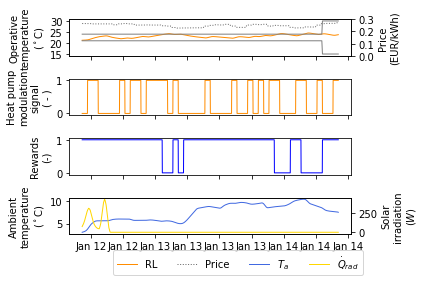

q(s,a) = 
[[0.    0.   ]
 [1.936 1.398]
 [0.594 0.   ]]
-------------------------------------------------------------------
Episode number: 2, starting day: 67.8 (from beginning of the year)


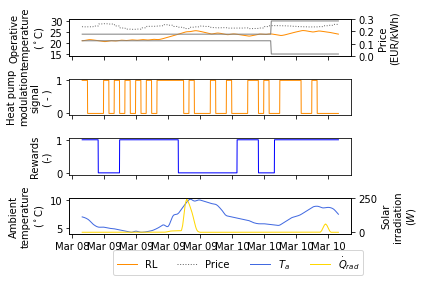

q(s,a) = 
[[0.    0.17 ]
 [2.414 2.116]
 [1.491 0.594]]
-------------------------------------------------------------------
Episode number: 3, starting day: 0.9 (from beginning of the year)


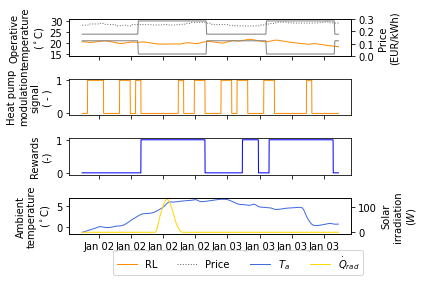

q(s,a) = 
[[1.594 1.141]
 [2.411 2.221]
 [1.491 0.594]]
-------------------------------------------------------------------
Episode number: 4, starting day: 29.9 (from beginning of the year)


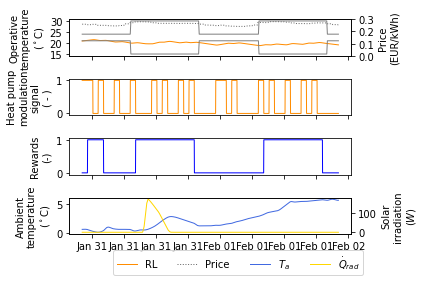

q(s,a) = 
[[2.411 2.219]
 [2.382 2.409]
 [1.491 0.594]]
-------------------------------------------------------------------
Episode number: 5, starting day: 19.8 (from beginning of the year)


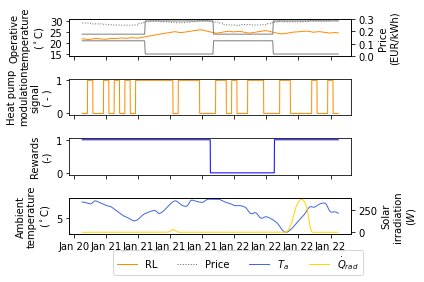

q(s,a) = 
[[2.411 2.219]
 [2.833 2.967]
 [2.287 1.918]]
-------------------------------------------------------------------
Episode number: 6, starting day: 11.0 (from beginning of the year)


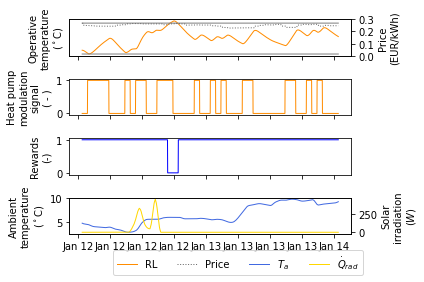

q(s,a) = 
[[2.411 2.219]
 [4.677 4.24 ]
 [2.367 1.918]]
-------------------------------------------------------------------
Episode number: 7, starting day: 45.2 (from beginning of the year)


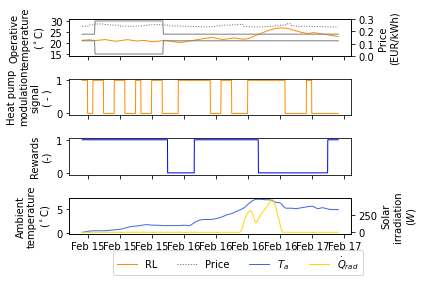

q(s,a) = 
[[2.452 3.17 ]
 [4.847 4.609]
 [2.432 1.997]]
-------------------------------------------------------------------
Episode number: 8, starting day: 362.2 (from beginning of the year)


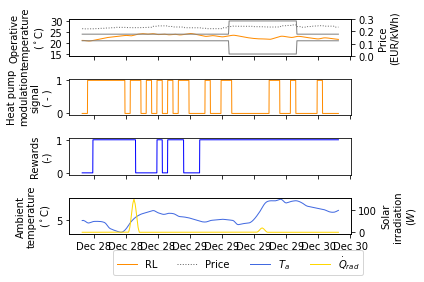

q(s,a) = 
[[2.452 3.271]
 [5.66  5.162]
 [2.737 2.014]]
-------------------------------------------------------------------
Episode number: 9, starting day: 72.3 (from beginning of the year)


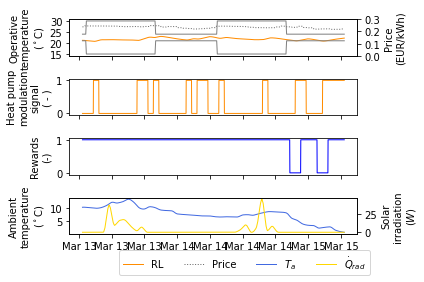

q(s,a) = 
[[2.452 3.917]
 [6.03  6.114]
 [2.737 2.014]]
-------------------------------------------------------------------
Episode number: 10, starting day: 357.8 (from beginning of the year)


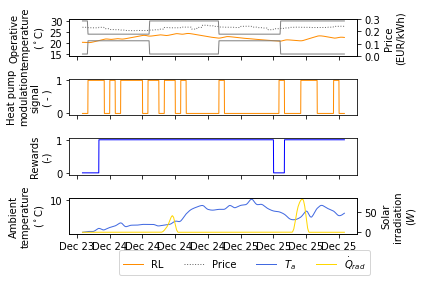

q(s,a) = 
[[2.56  4.458]
 [6.448 6.346]
 [3.256 2.165]]


In [20]:
model = Q_Learning_Agent(env, eps_min=0.01, eps_decay=0.001, alpha=0.1, gamma=0.9)
model.learn(total_episodes=10)

Since our environment has been defined with one-dimensional state and action spaces, we can plot the q-function after training as follows:


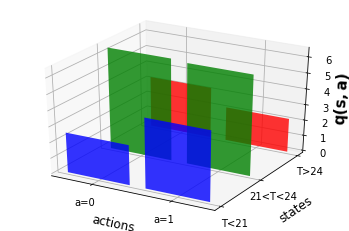

In [21]:
import matplotlib.pyplot as plt

acts   = ['a=0','a=1']
stas   = ['T<21', '21<T<24', 'T>24']
colors = ['b',    'g',       'r']

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('actions',           labelpad=6,  fontsize=12)
ax.set_ylabel('states',            labelpad=10, fontsize=12)
ax.set_zlabel('$\mathbf{q(s,a)}$', labelpad=0,  fontsize=15)
plt.xticks(ticks=range(len(acts)), labels=acts)
plt.yticks(ticks=range(len(stas)), labels=stas)

for i, s in enumerate(stas):
  x = np.arange(len(acts))
  h = model.q[i,:]

  # Set color
  color = [colors[i]]*len(acts)

  # Plot the 3D bar graph
  ax.bar(x, h, zs=i, zdir='y', color=color, alpha=0.8)

plt.show()

Does it sound familiar? this is actually the [q-function that we had conceptually introduced before](#qFunctionConcept), but for our specific case!

We observe that the state with the highest value is the one in the middle (green bars 🟢👌, `21<T<24`) because this is the one that keeps comfort. In that state, there is no significant difference between turning heating on or off. On the contrary, when temperature is below the comfort bound (blue bars 🔵🥶, `T<21`), there is more value on taking action `a=1`, so there is a preference for the agent to turn heating on. On the other hand, when temperature is above the comfort bound (red bars 🔴🔥, `T>24`), there is more value on `a=0`, so there is a preference for the agent to turn heating off. 

Sometimes it is useful to know what is the value of being on a specific state, independently of the action to be taken. This is represented by the so-called state-value function, which relates to the action-value function as follows:

\begin{align}
  v(\pmb{s}) = \max_{\pmb{a}} q(\pmb{s},\pmb{a})
\end{align}

At this point we can easily compute and plot the value function for our case:




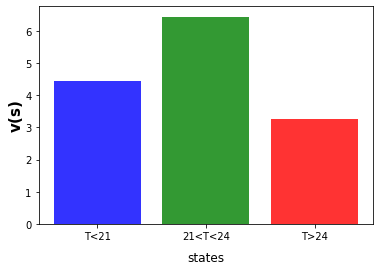

In [22]:
# Compute the state-value function
v = np.amax(model.q, axis=1)

# Plot state-value function
fig = plt.figure()

ax = fig.add_subplot(111)
ax.set_xlabel('states', labelpad=10, fontsize=12)
ax.set_ylabel('$\mathbf{v(s)}$', labelpad=0,  fontsize=15)
plt.xticks(ticks=range(len(stas)), labels=stas)
x = np.arange(len(stas))
ax.bar(x, v, color=colors, alpha=0.8)
plt.show()

Notice that we have trained our agent following an off-policy method: the actions were driven by a policy different than that one that our agent would follow. This is because the agent was using an epsilon-greedy policy to explore more rewarding actions. If we conclude we are happy with the learned policy, we can test it by setting `deterministic=True` with the `predict` method. For example, let's test our learned agent for the first day of February: 



In [23]:
env.stop()
env = BoptestGymEnvCustomReward(url                   = url,
                                testcase              = 'bestest_hydronic_heat_pump',
                                actions               = ['oveHeaPumY_u'],
                                observations          = {'reaTZon_y':(lower_setp,upper_setp)}, 
                                random_start_time     = False,
                                start_time            = 31*24*3600,
                                max_episode_length    = 24*3600,
                                warmup_period         = 24*3600,
                                step_period           = 3600)
env = DiscretizedActionWrapper(env, n_bins_act=1)
env = DiscretizedObservationWrapper(env, n_bins_obs=3, outs_are_bins=True)

done = False
obs = env.reset()

from IPython.display import clear_output
while not done:
  # Clear the display output at each step
  clear_output(wait=True)
  # Compute control signal 
  action = model.predict(obs, deterministic=True) 
  # Print the current operative temperature and decided action
  print('-------------------------------------------------------------------')
  print('State  [Bin #]  = {:.0f}'.format(obs))
  print('Action [ - ]    = {:.0f}'.format(action))
  print('-------------------------------------------------------------------')
  # Implement action 
  obs,reward,done,info = env.step(action) # send the action to the environment

-------------------------------------------------------------------
State  [Bin #]  = 1
Action [ - ]    = 0
-------------------------------------------------------------------


Now there is no randomness involved. The agent exploits its policy by ALWAYS picking action `a=1` when `s=0` because it has learned that that is the action with the highest value in that state. 

We can now evaluate our learned policy by calculating the core KPIs with BOPTEST:

In [24]:
env.get_kpis()

{'tdis_tot': 1.7415794961384694,
 'idis_tot': 0,
 'ener_tot': 0.17501300879744733,
 'cost_tot': 0.044365797730152895,
 'emis_tot': 0.029227172469173696,
 'pele_tot': 0.01990768126278055,
 'pgas_tot': None,
 'pdih_tot': None,
 'time_rat': 0.0003869439121605693}

This prepares the ground for different RL configurations to be evaluated and compared between each other and to other types of controls like classical rule based controllers or more advanced model predictive control. Recall that there are specific [scenario periods for each test case in BOPTEST](https://github.com/ibpsa/project1-boptest/tree/master/testcases#test-cases) that are set for these comparisons. 

**Food for thought:  🤔**
- If the agent never receives a reward when the temperature is out of the comfort bounds (states 0 🔵 and 2 🔴), why is the q-function not 0 for those states?
- Could you think of measures to improve learning?
- Could you think of measures to improve performance?


# **Gearing up** <a name="gearingUp"></a> 💪

The previously stylished example had a very limited representation of the state space. It was useful to illustrate how we can configure and train a RL agent without needing too many interactions with the environment (our building). However, using RL for solving this environment may feel like overkilling the problem. Our `SimpleController` was already enough to decide when to turn on heating based on indoor temperature readings. You should note, however, that you have developed a general agent capable of learning from any environment and the potential to infer way more complex relationships between environment observations and actions. Examples of what this RL agent could infer for building control are the following:
- Dynamic energy pricing
- A heating schedule based on user inputs. 
- A heating curve based on ambient temperature.
- The variable heat pump COP based on condenser, evaporator, and ambient temperature reaadings. 

We could for example extend our reward function as to minimize the building energy use or the greenhouse gas emissions while keeping comfort.
And all this can be inferred without the need of a model that requires domain knowledge. On the downside, learning more complex dynamics from higher dymensional observation spaces requires more training data. This means that more interactions with the environment (the building) are required, which sometimes are unavailable. For this reason, sample-efficiency is key in RL and there exist several tricks to expedite learning. 


To finalize, we are going to instantiate a more complete building environment by extending the observation space with the time of the week as well as information about the ambient temeprature, solar irradiation, internal gains, electricity pricing, or temperature setpoints. With BOPTEST-Gym we can also establish a predictive and a regressive period that include predictions of the boundary condition data and past observations of the measured data, respectively.   

In [ ]:
env.stop()

from boptestGymEnv import NormalizedObservationWrapper
from stable_baselines3 import DQN

env = BoptestGymEnvCustomReward(
        url                  = url,
        actions              = ['oveHeaPumY_u'],
        observations         = {'time':(0,604800),
                                'reaTZon_y':(280.,310.),
                                'TDryBul':(265,303),
                                'HDirNor':(0,862),
                                'InternalGainsRad[1]':(0,219),
                                'PriceElectricPowerHighlyDynamic':(-0.4,0.4),
                                'LowerSetp[1]':(280.,310.),
                                'UpperSetp[1]':(280.,310.)}, 
        predictive_period    = 24*3600, 
        regressive_period    = 6*3600, 
        random_start_time    = True,
        max_episode_length   = 7*24*3600,
        warmup_period        = 24*3600,
        step_period          = 900)
    
env = NormalizedObservationWrapper(env)
env = DiscretizedActionWrapper(env,n_bins_act=10)

This new environment has a way higher dimensional state-action space than the ones we treated before:

In [26]:
print('Observation space of the building environment (dimension):')
print(env.observation_space.shape)
print('Action space of the building environment:')
print(env.action_space)

Observation space of the building environment (dimension):
(608,)
Action space of the building environment:
Discrete(11)


Because of this high dimensional state-action space, an agent will probably require many more interactions to solve this environment. Luckily, there are readily available state-of-the-art RL algorithms that implement all sort of tricks to expedite and stabilize learning while maintain the learning principle that you have learned above. For example, we can access the advanced Deep Q-Network (DQN) algorithm from Stable-Baselines3 to learn this more complex environment. We set here our agent to learn for `10` steps to show how this learning process would be initiated. 
<!-- 
In those cases, the agent would probably take too long to learn for this tutorial, but I'd encourage you to try it out offline!  -->

In [27]:
model = DQN('MlpPolicy', env, verbose=1, gamma=0.99, seed=seed, 
            learning_rate=5e-4, batch_size=24, 
            buffer_size=365*24, learning_starts=24, train_freq=1)

# Main training loop
model.learn(total_timesteps=10)

Using cpu device
Wrapping the env in a DummyVecEnv.


However, this is clearly not enough! Solving an environment of these dimensions would probably require millions of steps or other tricks to accelerate learning. Could you think of any?

In [28]:
env.stop()

# **Further resources** <a name="furtherResources"></a> 📚

- For RL, check out the resources page from Stable-Baselines 3 [here](https://stable-baselines3.readthedocs.io/en/master/guide/rl.html) and the [open access book of Richard S. Sutton and Andrew G. Barto](http://incompleteideas.net/book/the-book-2nd.html) 
- For BOPTEST, check out the websites of the [BOPTEST framework](https://ibpsa.github.io/project1-boptest/), its [GitHub repository](https://ibpsa.github.io/project1-boptest/), and its overarching project: [IBPSA Project 1](https://ibpsa.github.io/project1/). 

# **Feedback** <a name="feedbackForm"></a> 💬 

Please help us improve by filling out [this form](https://forms.gle/JdprK6tgxQtwvhFV8). It'll only take a couple of minutes!

#**Annex I: Formal Reinforcement Learning theory** <a name="theoryRlFormal"></a>

In RL we aim to derive an optimal control policy from the direct interaction of an agent (the RL algorithm) and an environment (the process to be optimized).
A policy is a mapping from environment states to actions that the agent "decides" to take. 
This control method is based on the principle of dynamic programming. Unlike
classical dynamic programming, RL does not assume the existence of a perfect
system model and uses function approximations to build a policy from samples
of historical data. Hence, the agent performs empirical learning and decides on
actions to drive the environment towards favorable trajectories according to a reward function that the environment delivers every control step.

The process of the RL agent interacting with the environment is a sequential decision-making problem formalized as a **Markov Decission Process (MDP)**. A diagram summarizing the RL approach is shown in the following figure:

<img src="https://drive.google.com/uc?id=10EbdxTgq4PLl2oQp_quLHrht59pDMob6" width="500"/>

*Figure: Diagram of the RL approach. The RL agent decides an action. After the action is implemented, the environment returns the new state $\pmb{S}_{k+1}$ and associated reward $R_{k+1}$.*

In an MDP, the agent and the environment interact during a sequence of discrete-time steps indexed here as $k=0,1,2,...,K$, with $K$ being the terminal sample that could be $K=\infty$. 
Every time step $k$ the agent receives a representation of the environment named state: $\pmb{S}_k \in \pmb{\mathcal{S}}$, where $\pmb{\mathcal{S}}$ is the state space. 
Note that the agent's observation of the state-space may or may not fully characterize the environment state. 
In the latter case where the agent can only see a partial observation of the environment's state-space, we refer to **partially observable Markov decision processes (POMDPs)**.

Upon receiving the state representation, the agent computes its control logic and in turn sends back to the environment a control action $\pmb{A}_k \in \pmb{\mathcal{A}}$, where $\pmb{A}_k$ is the most appropriate action chosen from the action space $\pmb{\mathcal{A}}$. 
One time step later, the agent observes a new state from the environment $\pmb{S}_{k+1}$ along with a scalar value indicating its reward $R_{k+1} \in \mathcal{R} \subset{\mathbb{R}}$. Notice that the reward $R_{k+1}$ is an indicator of the agent's performance when taking action $\pmb{A}_k$ from state $\pmb{S}_k$.

The environment $\mathcal{E}_{\pmb{f}}$ is governed by the natural laws of the system dynamics $\pmb{f}$ and it is defined by $\mathcal{E}_{\pmb{f}}:\pmb{\mathcal{S}}\times \pmb{\mathcal{A}} \rightarrow \pmb{\mathcal{S}}\times \mathcal{R}$. 
The goal of RL is to infer an **optimal control policy** $\pi_{*}:\pmb{\mathcal{S}} \rightarrow \pmb{\mathcal{A}}$ that maximizes the **expected cumulative return** $G$ when the agent acts according to it. 
The cumulative return is defined as some function of the rewards sequence, and a typical definition is to discount the rewards with a **discount factor** $\gamma \in [0,1]$ as shown in the following equation:

\begin{align}
  G_k = R_{k+1} + \gamma R_{k+2} + \gamma^2 R_{k+3} + ... = \sum_{i=0}^\infty \gamma^i R_{k+i+1}
\end{align}

The **action-value function** $q(\pmb{S},\pmb{A})$ estimates the expected return when being in a specific state $\pmb{S}$ and taking an action $\pmb{A}$.
The **state-value function** $v(\pmb{S})$ directly estimates the expected return for being in state $\pmb{S}$.
Frequently, the policy and value functions are approximated by **function approximations** to cope with high-dimensional state-action spaces. 
Examples of commonly used regressors are neural networks or randomized trees. 

<!-- Both value functions can be related as shown in the equation below.
\begin{equation}
    v(\pmb{S}) = \max_{\pmb{a}\in\pmb{\mathcal{A}}} q(\pmb{S}, \pmb{a})
\end{equation} -->

A **trajectory** of an MDP is defined as a sequence of states, actions and rewards.
Most of the RL algorithms learn from finite trajectories of experience called **episodes**.
Sometimes, the trajectories are broken down into tuples of the form $(\pmb{s}_k,\pmb{a}_k,r_k,\pmb{s}_{k+1})$ and stored in a **replay memory** $\pmb{\mathcal{D}}$. 
Using a replay memory allows to serve the historical data in random batches of tuples to preserve as much as possible the independent and identically distributed assumption that is typically taken to parametrize policies and value functions. 



# **References** <a name="references"></a>


- **[1]** *Blum, D., Arroyo, J., Huang, S., Drgona, J., Jorissen, F., Taxt Walnum, H., Yan, C., Benne, K., Vrabie, D., Wetter, M., and Helsen,
L. Building Optimization Testing Framework (BOPTEST) for Simulation-
Based Benchmarking of Control Strategies in Buildings. Journal of Building
Performance Simulation 14, 5 (2021), 586–610. https://doi.org/10.1080/19401493.2021.1986574*

- **[2]** *Arroyo, J., Manna, C., Spiessens, F., and Helsen, L. An OpenAI-Gym
environment for the Building Optimization Testing (BOPTEST) framework.
In Proceedings of the 17th IBPSA Conference (Bruges, Belgium, September 2021) [https://doi.org/10.26868/25222708.2021.30380](https://www.conftool.pro/bs2021/index.php/30380_Arroyo_Javier.pdf?page=downloadPaper&filename=30380_Arroyo_Javier.pdf&form_id=30380)* 

- **[3]** *Drgona, J., Arroyo, J., Cupeiro Figueroa, I., Blum, D., Arendt, K., Kim, D.,Ollé, E. P., Oravec, J., Wetter, M., Vrabie, D. L., and Helsen, L. All you need to know about model predictive control for buildings. Annual Reviews in Control 50 (2020), 190–232. https://doi.org/10.1016/j.arcontrol.2020.09.001*

- **[4]** *Vázquez-Canteli, J. R., and Nagy, Z. Reinforcement learning
for demand response: A review of algorithms and modeling techniques.
Applied energy 235 (2019), 1072–1089. https://doi.org/10.1016/j.apenergy.2018.11.002*

- **[5]** *Chen, B., Cai, Z., and Bergés, M. Gnu-RL: A Practical and Scalable Reinforcement Learning Solution for Building HVAC Control Using a Differentiable MPC Policy. Frontiers in Built Environment 6 (2020). https://doi.org/10.3389/fbuil.2020.562239*

- **[6]** *Sutton, R. S., and Barto, A. G. Reinforcement Learning: An Introduction, second ed. The MIT Press, 2018.*
